# Pricing equity index options in Euro
In this notebook I price equity index options using volatility tracking, riskless yield curve construction, and options pricing code from this package. I ensure that all market and economic data required for pricing is obtained from [FRED](https://fred.stlouisfed.org), [Eurostat](https://ec.europa.eu/eurostat/data/database), and [Yahoo-finance](https://finance.yahoo.com) using [pandas-datareader](https://pydata.github.io/pandas-datareader/).

This notebook can also be used as a tutorial to using the `pricing.curves`, `pricing.options`, `volatility.parameter_estimators`, and `volatility.volatility_trackers` packages in this repository.

## Constructing a riskless yield curve for Euro
Since I already covered it in a separate notebook, I will simply import it. The resultant YieldCurve object is
assigned to the `curve` variable

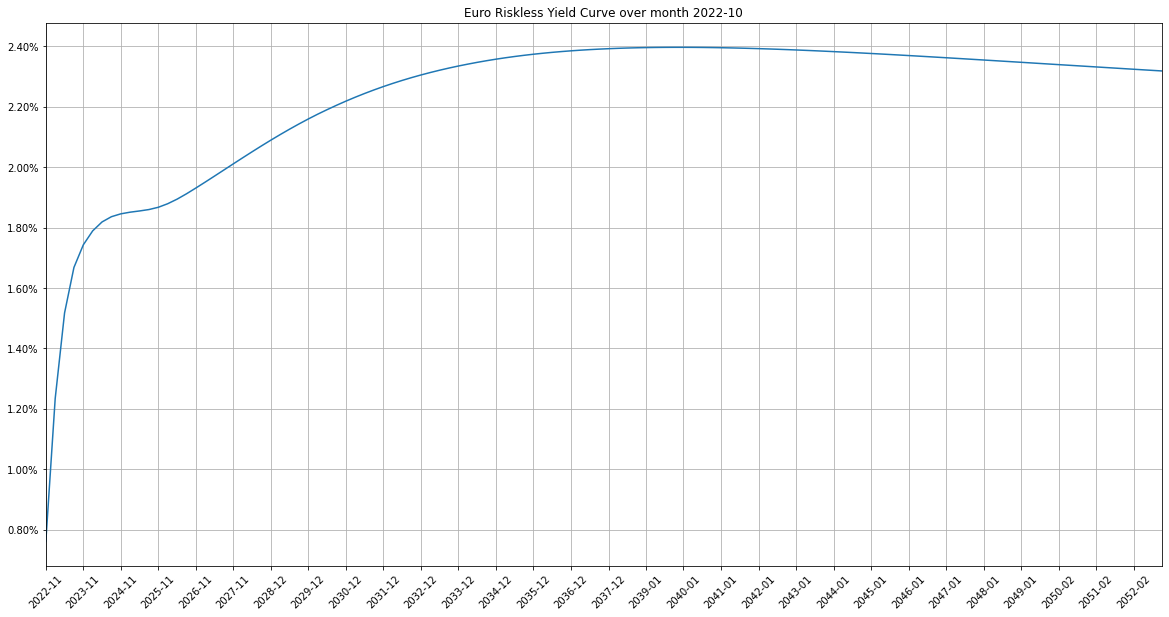

In [1]:
%run euro-riskless-yield-construction-example.ipynb

## Estimating and forecasting volatility of the index, options on which we want to price
Now that the riskless curve has been constructed, the next thing to do is obtain an accurate volatility estimate for the index whose options we want to price. There are various methods for doing it. The most common are the Exponentially Weighted Moving Average (EWMA) and GARCH(1, 1) methods. You can read about them on the Internet or delve into John C. Hull's [Risk Management and Financial Institutions](http://www-2.rotman.utoronto.ca/~hull/riskman/index.html) or [Options, Futures, and Other Derivatives](http://www-2.rotman.utoronto.ca/~hull/ofod/index.html). For the purposes of pricing options GARCH(1, 1) is preferred because it supports volatility forecasting for future maturities by incorporating mean reversion (and volatility of equities lends itself to mean reversion). In this notebook I therefore use GARCH(1, 1).

### GARCH(1, 1)
In order to use GARCH(1, 1) one first needs to estimate it's parameters based on the historical data for the equity whose options you want to price. GARCH(1, 1) has three parameters &mdash; ω, α, and β. I use the maximum likelihood method to estimate them, which is an optimization task. The `volatility.parameter_estimators.GARCHParameterEstimator` class comes to rescure. _Implementation detail_: In that class I use [SciPy](https://docs.scipy.org/doc/scipy/tutorial/optimize.html) to optimize for maximum likelihood. Alternatively I could've used Google's TensorFlow 2.x. *NB* When estimating ω, α, and β it's vital to use _adjusted closing_ prices, i.e. prices that have been adjusted for dividends and stock splits. Failing to do that will result in too high an estimate. Yahoo Finance provides such prices in the `Adj Close` column.

#### Estimating GARCH(1, 1) parameters for AEX (^AEX)
The AEX index is a capitalization-weighted index composed of 25 large capitalization Dutch companies.

In [2]:
TICKER = '^AEX'

# I'll use price changes since 1st Jan 2018 to estimate GARCH(1, 1) ω, α, and β parameters
start = date(2018, 1, 1)
data = web.get_data_yahoo(TICKER, start, today)
asset_prices = data['Adj Close']

vol_estimator = parameter_estimators.GARCHParameterEstimator(asset_prices)
print('Optimal values for GARCH(1, 1) parameters:\n\tω=%.12f, α=%.5f, β=%.5f'
      % (vol_estimator.omega, vol_estimator.alpha, vol_estimator.beta))

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Objective function: 10179.97572 after 141 iterations
Optimal values for GARCH(1, 1) parameters:
	ω=0.000006173933, α=0.17590, β=0.78486


#### Forecasting volatility for AEX
Now that we have the obtined optimal values for GARCH(1, 1) parameters ω, α, and β, we can proceed to forecast S&P 500 volatility. I crated class `volatility.parameter_estimators.GARCHVolatilityTracker` to assist in it.

In [4]:
vol_tracker = volatility_trackers.GARCHVolatilityTracker(vol_estimator.omega, vol_estimator.alpha,
                                                         vol_estimator.beta, asset_prices)

# Let's get volatility forecast for June 16th 2023 options
maturity_date = date(2023, month=6, day=16)
vol = vol_tracker.get_annual_term_volatility_forecast(curve.to_years(maturity_date))
print('Volatility of %s for term %.4f years: %.5f' % (TICKER, curve.to_years(maturity_date), vol))

Volatility of ^AEX for term 0.5863 years: 0.20831


#### Optional: Visualizing volatility term structure of AEX index for 200 business days into the future
In contrast to the `equity-options-pricing-example.ipynb` notebook where I visualized historical, and future volatilities, in this notebook I'll visualize volatility term structure for AEX, i.e. forecast average volatility for a certain future term expressed in years.

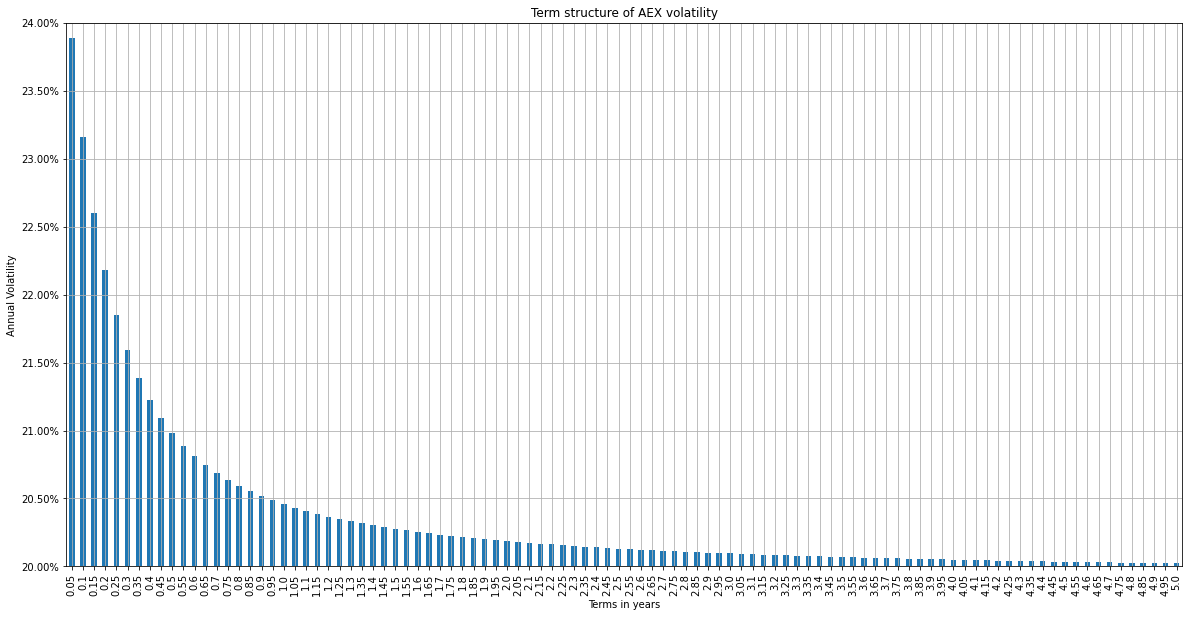

In [5]:
from math import floor, ceil

terms = [x / 100 for x in range(5, 505, 5)]
term_vols = [vol_tracker.get_annual_term_volatility_forecast(term) * 100 for term in terms]
series = pd.Series(term_vols, index=terms)

ax = series.plot(figsize=(20,10), grid=True, kind='bar', title='Term structure of AEX volatility')
ax.set_ylim(bottom=floor(series.min()), top=ceil(series.max()))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Annual Volatility')
_ = ax.set_xlabel('Terms in years')

## Pricing using Black-Scholes-Merton Pricer
The Black-Scholes-Merton model can be used to price European options, including equity indices. With enough customizations it can also be used to price American call options (even those paying dividends or having a known
dividend yield). Exchange and over-the-counter traded equity index options tend to be European.

Let's put it to use to price an AEX call and put options with a strike of 700. Some of the stocks comprising AEX pay dividends. It's essential to take into account the expected dividend yield of AEX to achieve accurate pricing. 

In [6]:
strike = 700.

# Expected AEX dividend yield
q = .039

cur_price = asset_prices[-1]
pricer = options.BlackScholesMertonPricer(maturity_date, vol_tracker, strike, curve, cur_price,
                                          ticker=TICKER, q=q)
print(pricer)

put_pricer = options.BlackScholesMertonPricer(maturity_date, vol_tracker, strike, curve, cur_price, is_call=False,
                                              ticker=TICKER, q=q)
print(put_pricer)

^AEX EUROPEAN call option with strike 700.0 and maturity 2023-06-16, price: 40.67, σ: 0.2083, Δ: 0.496, Γ: 0.003, ν: 209.823
^AEX EUROPEAN put option with strike 700.0 and maturity 2023-06-16, price: 47.25, σ: 0.2083, Δ: -0.481, Γ: 0.003, ν: 209.823


Sometimes you might want to price using _an implied volatility_ for the expiry date, implied volatilities are volatilities implied by option prices of market makers. You can easily use implied volatilities with 
the `BlackScholesMertonPricer` class, just pass the volatility value as the second parameter instead of
a volatility tracker:

In [7]:
impl_vol = .24

pricer = options.BlackScholesMertonPricer(maturity_date, impl_vol, strike, curve, cur_price,
                                          ticker=TICKER, q=q)
print(pricer)

put_pricer = options.BlackScholesMertonPricer(maturity_date, impl_vol, strike, curve, cur_price, is_call=False,
                                              ticker=TICKER, q=q)
print(put_pricer)

^AEX EUROPEAN call option with strike 700.0 and maturity 2023-06-16, price: 47.31, σ: 0.2400, Δ: 0.504, Γ: 0.003, ν: 209.697
^AEX EUROPEAN put option with strike 700.0 and maturity 2023-06-16, price: 53.90, σ: 0.2400, Δ: -0.473, Γ: 0.003, ν: 209.697


## Pricing using Binomial Tree Pricer
The Binomial Tree model can be used to price any European or American option, including on index some of whose constituent stocks pay dividends.

Let's put it to use to price an AEX call and put option with a strike of 700 and compare resulting prices with those obtained from the BlackScholesMertonPricer.

In [8]:
bin_tree_pricer = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve, cur_price,
                                             ticker=TICKER, q=q)
print(bin_tree_pricer)

print('Price difference between Black-Scholes-Merton and Binomial Treee pricers for calls: %.6f'
      % abs(pricer.get_price() - bin_tree_pricer.get_price()))
bin_tree_put_pricer = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve, cur_price, is_call=False,
                                                 ticker=TICKER, q=q)
print(bin_tree_put_pricer)

print('Price difference between Black-Scholes-Merton and Binomial Treee pricers for puts: %.6f'
      % abs(put_pricer.get_price() - bin_tree_put_pricer.get_price()))

^AEX EUROPEAN call option with strike 700.0 and maturity 2023-06-16, price: 47.04, σ: 0.2400, Δ: 0.505, Γ: 0.003, ν: 207.742
Price difference between Black-Scholes-Merton and Binomial Treee pricers for calls: 0.276217
^AEX EUROPEAN put option with strike 700.0 and maturity 2023-06-16, price: 53.62, σ: 0.2400, Δ: -0.473, Γ: 0.003, ν: 207.742
Price difference between Black-Scholes-Merton and Binomial Treee pricers for puts: 0.276183


Now pricing with our volatility forecast:

In [9]:
bin_tree_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve, cur_price,
                                             ticker=TICKER, q=q)
print(bin_tree_pricer)

bin_tree_put_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve, cur_price, is_call=False,
                                                 ticker=TICKER, q=q)
print(bin_tree_put_pricer)

^AEX EUROPEAN call option with strike 700.0 and maturity 2023-06-16, price: 40.45, σ: 0.2083, Δ: 0.497, Γ: 0.004, ν: 207.888
^AEX EUROPEAN put option with strike 700.0 and maturity 2023-06-16, price: 47.04, σ: 0.2083, Δ: -0.481, Γ: 0.004, ν: 207.888
